# NLP predict language from readme - Harry Potter

In [1]:
import acquire
import prepare
import wrangle
import explore
import model
import curie_model
explore.set_plotting_defaults()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Acquire

In [2]:
df = acquire.get_github_HPresults(cached=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 0 to 655
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  656 non-null    object
 1   content   656 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


# Prepare

In [4]:
df = prepare.prep_data(df, 'content', extra_words=['harry', 'potter', 'run', 'file', 'house'], exclude_words=[])

In [5]:
df.shape

(442, 7)

In [6]:
train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split(df, 'language')

In [7]:
X_train.shape, X_validate.shape, X_test.shape

((264, 6), (89, 6), (89, 6))

# Explore

In [8]:
# check balance of dataset for under/over sampling
explore.check_proportion(train_exp)
# balance is not bad, will not need to over/under sample

,n,percent
JavaScript,103,0.390152
Java,61,0.231061
Python,54,0.204545
HTML,46,0.174242


In [9]:
# create a list of words for each language category and remove single letter words
python_words, js_words, html_words, java_words = explore.create_lang_word_list(train_exp)
# get the count of words by category
python_freq, js_freq, html_freq, java_freq = explore.get_count_word_freq(python_words, js_words, html_words, java_words)

In [10]:
python_freq
# words to add to stopwords = harry, potter, file 

use            28
image          27
file           24
python         22
using          20
               ..
default         1
acquired        1
exactly         1
attribution     1
choose          1
Length: 1280, dtype: int64

In [11]:
js_freq
# words to add to stopwords = harry, potter, run

build                           327
app                             301
npm                             286
test                            274
use                             265
                               ... 
somewhere                         1
bertie                            1
firewhisky                        1
httplocalhost4034apiscenario      1
buttom                            1
Length: 4311, dtype: int64

In [12]:
html_freq
# words to add to stopwords = harry, potter, file, house

spell                21
&#9;                 21
use                  14
option               13
make                 13
                     ..
appget'               1
nodemonignore         1
spelldone             1
activate              1
harrypottertrivia     1
Length: 1202, dtype: int64

In [13]:
java_freq
# words to add to stopwords = harry, potter, run, house

de           189
build        143
test         126
use          123
npm          120
            ... 
snippet        1
msflexbox      1
whether        1
performed      1
excluded       1
Length: 3440, dtype: int64

In [14]:
# Top 5 words for all languages are now unique

In [15]:
# combine list of word counts into df for further exploration
word_counts = explore.create_df_word_counts(python_freq, js_freq, html_freq, java_freq)
word_counts = explore.word_counts_proportion(word_counts)

In [16]:
word_counts

,Python,JavaScript,HTML,Java,all_words,prop_python,prop_js,prop_html,prop_java
&#9;,0,12,21,1,34,0.0,0.352941,0.617647,0.029412
&#9;content',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
&#9;tag',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
&#9;title',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
000000,0,1,0,1,2,0.0,0.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
zone,0,1,0,0,1,0.0,1.000000,0.000000,0.000000
zonko,0,1,0,0,1,0.0,1.000000,0.000000,0.000000
zum,0,0,0,1,1,0.0,0.000000,0.000000,1.000000
zusatzlich,0,0,0,1,1,0.0,0.000000,0.000000,1.000000


In [17]:
print("The number of words that occur n times: ")
word_counts['all_words'].value_counts().head(20)

The number of words that occur n times: 


1     2326
2      976
3      892
4      322
6      308
9      131
5      118
8      104
7       81
12      69
10      65
15      51
13      43
11      41
18      30
14      30
17      30
16      27
24      24
22      23
Name: all_words, dtype: int64

In [18]:
# filter out all words that occur less than 20 times
word_counts = word_counts[word_counts['all_words'] >= 20]
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465 entries, &#9; to youre
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Python       465 non-null    int64  
 1   JavaScript   465 non-null    int64  
 2   HTML         465 non-null    int64  
 3   Java         465 non-null    int64  
 4   all_words    465 non-null    int64  
 5   prop_python  465 non-null    float64
 6   prop_js      465 non-null    float64
 7   prop_html    465 non-null    float64
 8   prop_java    465 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 36.3+ KB


<Figure size 864x576 with 0 Axes>

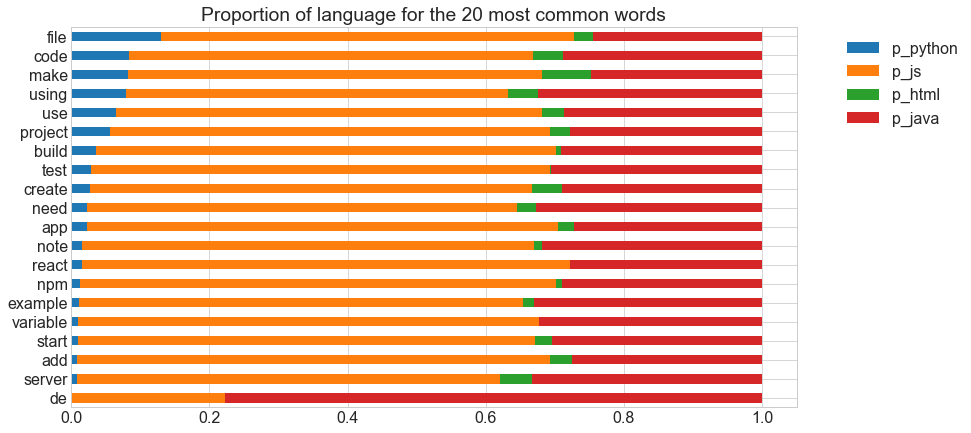

In [19]:
# visualize the % of the term in each language
explore.proportion_visualization(word_counts)

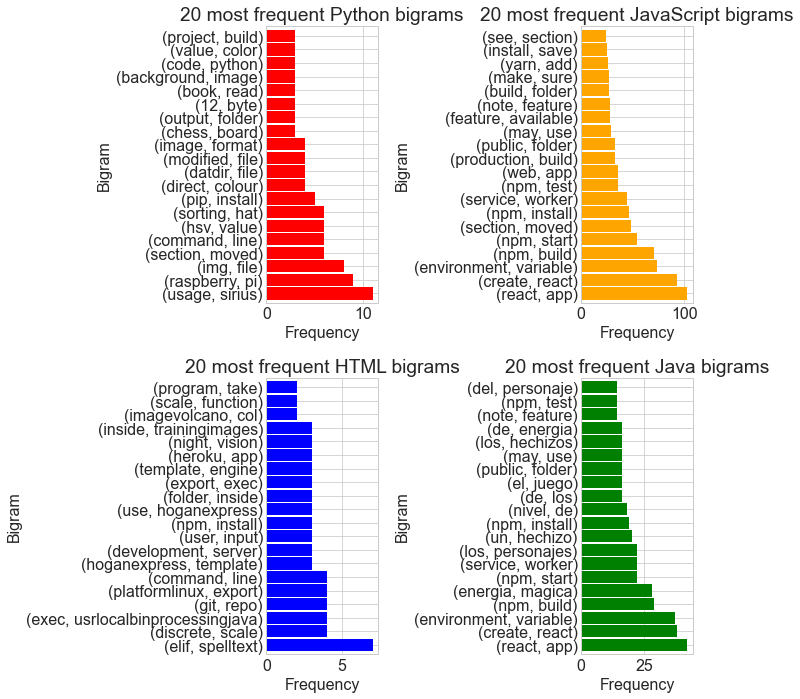

In [20]:
python_bigrams, js_bigrams, html_bigrams, java_bigrams = explore.create_bigrams(python_words, js_words, html_words, java_words)
explore.plot_bigrams(python_bigrams, js_bigrams, html_bigrams, java_bigrams)

# Model

In [31]:
X_train.head()

,content,clean,stemmed,lemmatized,words,doc_length,pred_bow,pred_tfidf
552,HarryPotterGame\nHarry Potter Game made in Con...,harrypottergame game made construct 2 try righ...,harrypottergam game made construct 2 tri right...,harrypottergame game made construct 2 try righ...,"[harrypottergame, game, made, constructtry, ri...",6,JavaScript,JavaScript
403,Harry Potter RPG\nThis is a simple Harry Potte...,rpg simple rpg game select character opponent ...,rpg simpl rpg game select charact oppon battl ...,rpg simple rpg game select character opponent ...,"[rpg, simple, rpg, game, select, character, op...",28,JavaScript,JavaScript
143,"The Harry Potter game is a fun, easy to play Q...",game fun easy play quintusstyle game watch dem...,game fun easi play quintusstyl game watch deme...,game fun easy play quintusstyle game watch dem...,"[game, fun, easy, play, quintusstyle, game, wa...",40,JavaScript,JavaScript
608,HarryPotterKata\nSolve Harry Potter kata pairi...,harrypotterkata solve kata pairing marina mari...,harrypotterkata solv kata pair marina marisid ...,harrypotterkata solve kata pairing marina mari...,"[harrypotterkata, solve, kata, pairing, marina...",10,JavaScript,Python
206,harryPotterSeattle\nThis app is an app that he...,harrypotterseattle app app helps tour seattle ...,harrypotterseattl app app help tour seattl tak...,harrypotterseattle app app help tour seattle t...,"[harrypotterseattle, app, app, help, tour, sea...",17,JavaScript,Java


In [41]:
# create vectorizers

# Bag of Words
vectorizer = CountVectorizer(stop_words='english', min_df=20, ngram_range=(1,2), binary=True)
# Learn vocabulary in sentences and Transform each sentences in vector space.
X_train_bow = vectorizer.fit_transform(X_train.clean)
# Transform validate and test
X_val_bow = vectorizer.transform(X_validate.clean)
X_test_bow = vectorizer.transform(X_test.clean)

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', min_df=20, ngram_range=(1,2), binary=True)
X_train_tfidf = tfidf.fit_transform(X_train.clean)
# Transform validate and test
X_val_tfidf = tfidf.transform(X_validate.clean)
X_test_tfidf = tfidf.transform(X_test.clean)

In [42]:
# Get Baseline - predict JavaScript for all
baseline = len(train_exp[train_exp.language == 'JavaScript']) / len(train_exp)
round(baseline,2)

0.39

## TRAIN

X_train.shape, X_validate.shape, X_test.shape 
((132, 6), (45, 6), (45, 6))  
X_train.shape, X_validate.shape, X_test.shape
  ((264, 6), (89, 6), (89, 6))

USING LEMMATIZED

|FUNCTION            |VECTOR| F1 range | Accuracy |    |FUNCTION            |VECTOR| F1 range | Accuracy |    
|--------------------|------|----------|----------|    |--------------------|------|----------|----------|    
|Logistic Regression |BOW   |.37 to .68| .58      |    |Logistic Regression |BOW   |.25 to .68| .61      |    
|Logistic Regression |TFIDF |.37 to .67| .56      |    |Logistic Regression |TFIDF |.23 to .66| .58      |    
|Random Forest       |BOW   |.31 to .68| .59      |    |Random Forest       |BOW   |.12 to .64| .58      |    
|Random Forest       |TFIDF |.43 to .78| .68      |    |Random Forest       |TFIDF |.12 to .65| .59      |    
|ComplementNaiveBayes|TFIDF |.33 to .63| .54      |    |ComplementNaiveBayes|TFIDF |.42 to .67| .57      |    

NEW RESULTS USING CLEAN (THOSE ARE BETTER THAN CONTENT, BUT STILL IN SAME RANGE AS LEMMATIZED)

In [43]:
# Logistic Regression
lm_bow, lm_tfidf = model.logistic_regression(X_train, y_train, X_train_bow, X_train_tfidf)

X_bow Accuracy: 59%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           3     6          33       4
Java           0    29          29       3
JavaScript     2     4          94       3
Python         0     4          21      29

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.60      0.07      0.12        46
        Java       0.67      0.48      0.56        61
  JavaScript       0.53      0.91      0.67       103
      Python       0.74      0.54      0.62        54

    accuracy                           0.59       264
   macro avg       0.64      0.50      0.49       264
weighted avg       0.62      0.59      0.54       264

-----------------------
TF-IDF Accuracy: 58%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language           

In [44]:
rf_bow, rf_tfidf = model.random_forest(X_train, y_train, X_train_bow, X_train_tfidf)

X_bow Accuracy: 56%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           2     2          39       3
Java           0    27          34       0
JavaScript     0     3          96       4
Python         0     0          30      24

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       1.00      0.04      0.08        46
        Java       0.84      0.44      0.58        61
  JavaScript       0.48      0.93      0.64       103
      Python       0.77      0.44      0.56        54

    accuracy                           0.56       264
   macro avg       0.78      0.47      0.47       264
weighted avg       0.72      0.56      0.51       264

-----------------------
TF-IDF Accuracy: 57%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                 

In [45]:
# ComplementNB 
cnb_tfidf = model.complement_naive_bayes(X_train, y_train, X_train_tfidf)

TF-IDF Accuracy: 53%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML          22     8          12       4
Java          17    31          10       3
JavaScript    32     8          55       8
Python        16     3           2      33

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.25      0.48      0.33        46
        Java       0.62      0.51      0.56        61
  JavaScript       0.70      0.53      0.60       103
      Python       0.69      0.61      0.65        54

    accuracy                           0.53       264
   macro avg       0.56      0.53      0.54       264
weighted avg       0.60      0.53      0.55       264



## VALIDATE


|FUNCTION            |VECTOR| F1 range | Accuracy |     |FUNCTION            |VECTOR| F1 range | Accuracy |     
|--------------------|------|----------|----------|     |--------------------|------|----------|----------|     
|Logistic Regression |BOW   |.00 to .67| .47      |     |Logistic Regression |BOW   |.00 to .61| .53      |     
|Logistic Regression |TFIDF |.00 to .62| .44      |     |Logistic Regression |TFIDF |.00 to .65| .56      |     
|Random Forest       |BOW   |.00 to .62| .44      |     |Random Forest       |BOW   |.00 to .58| .47      |     
|Random Forest       |TFIDF |.00 to .62| .47      |     |Random Forest       |TFIDF |.00 to .60| .48      |     
|ComplementNaiveBayes|TFIDF |.21 to .67| .40      |     |ComplementNaiveBayes|TFIDF |.37 to .65| .52      |     



In [46]:
model.validate_logistic_regression(X_validate, y_validate, X_val_bow, X_val_tfidf, lm_bow, lm_tfidf)

X_bow Accuracy: 52%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    Java  JavaScript  Python
language                            
HTML           1          13       2
Java           7          12       1
JavaScript     1          31       3
Python         1           9       8

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        16
        Java       0.70      0.35      0.47        20
  JavaScript       0.48      0.89      0.62        35
      Python       0.57      0.44      0.50        18

    accuracy                           0.52        89
   macro avg       0.44      0.42      0.40        89
weighted avg       0.46      0.52      0.45        89

-----------------------
TF-IDF Accuracy: 53%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  Java  JavaScript  Python
language                            
HTML           1        

In [47]:
model.validate_random_forest(X_validate, y_validate, X_val_bow, X_val_tfidf, rf_bow, rf_tfidf)

X_bow Accuracy: 49%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    Java  JavaScript  Python
language                            
HTML           1          14       1
Java           5          15       0
JavaScript     2          32       1
Python         0          11       7

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        16
        Java       0.62      0.25      0.36        20
  JavaScript       0.44      0.91      0.60        35
      Python       0.78      0.39      0.52        18

    accuracy                           0.49        89
   macro avg       0.46      0.39      0.37        89
weighted avg       0.47      0.49      0.42        89

-----------------------
TF-IDF Accuracy: 49%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  Java  JavaScript  Python
language                            
HTML           0          15  

In [48]:
model.validate_complement_naive_bayes(X_validate, y_validate, X_val_tfidf, cnb_tfidf)

TF-IDF Accuracy: 51%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML          10     1           3       2
Java           6     9           5       0
JavaScript    12     3          17       3
Python         7     0           2       9

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.29      0.62      0.39        16
        Java       0.69      0.45      0.55        20
  JavaScript       0.63      0.49      0.55        35
      Python       0.64      0.50      0.56        18

    accuracy                           0.51        89
   macro avg       0.56      0.52      0.51        89
weighted avg       0.58      0.51      0.52        89



## TEST


|FUNCTION            |VECTOR| F1 range | Accuracy |  |FUNCTION            |VECTOR| F1 range | Accuracy |  
|--------------------|------|----------|----------|  |--------------------|------|----------|----------|  
|Logistic Regression |BOW   |.00 to .67| .58      |  |Logistic Regression |BOW   |.12 to .72| .54      |  
|Random Forest       |TFIDF |.00 to .65| .58      |  |Random Forest       |TFIDF |.00 to .71| .53      |




In [49]:
model.test_logistic_regression(X_test, y_test, X_test_bow, lm_bow)

X_bow Accuracy: 53%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    Java  JavaScript  Python
language                            
HTML           1          12       2
Java           2          17       2
JavaScript     2          30       3
Python         0           3      15

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        15
        Java       0.40      0.10      0.15        21
  JavaScript       0.48      0.86      0.62        35
      Python       0.68      0.83      0.75        18

    accuracy                           0.53        89
   macro avg       0.39      0.45      0.38        89
weighted avg       0.42      0.53      0.43        89



In [50]:
model.test_random_forest(X_test, y_test, X_test_tfidf, rf_tfidf)

TF-IDF Accuracy: 51%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  Java  JavaScript  Python
language                            
HTML           0          15       0
Java           3          18       0
JavaScript     1          32       2
Python         0           8      10

-----------------------
TF-IDF Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        15
        Java       0.75      0.14      0.24        21
  JavaScript       0.44      0.91      0.59        35
      Python       0.83      0.56      0.67        18

    accuracy                           0.51        89
   macro avg       0.51      0.40      0.37        89
weighted avg       0.52      0.51      0.42        89

